## Step 0: Setup & Load The Data
<a href="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip" target="_blank">Link to download data set</a>

In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import SGD

from keras.models import model_from_json
import json

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load pickled data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

In [3]:
# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


9


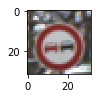

In [4]:
# plot a random training image
plt.subplot(3,1,1)
index = random.randint(0, len(X_train))
image = X_train[index].astype(np.uint8)
plt.imshow(image)
print(y_train[index])

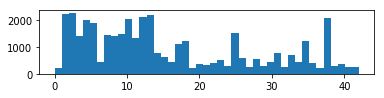

In [5]:
# plot label distribution of training examples
plt.subplot(3,1,2)
n, bins, patches = plt.hist(y_train, 43)

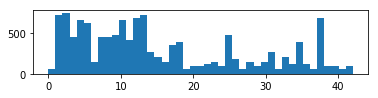

In [6]:
# plot label distribution of test examples
plt.subplot(3,1,3)
n, bins, patches = plt.hist(y_test, 43)

## Step 2: Data augmentation

In [7]:
# random brightness
def random_brightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(low=0.5, high=1.2)
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

# random blur
def random_blur(image):
    blur = np.random.randint(2)
    if blur:
        image = cv2.GaussianBlur(image,(5,5),0)
    return image


# img_reader
def img_generator(image):
    # augmentation pipeline
    image = image.astype(np.uint8)
    image = random_brightness(image)
    image = random_blur(image)
    return image

In [8]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

x_train = {}
for i in range(43):
    x_train[i] = []

for i in range(len(X_train)):
    image = X_train[i]
    label = y_train[i]
    x_train[label].append(image)

min_instance = 2200

for i in range(43):
    if(len(x_train[i]) < min_instance):
        x_add = []
        while(len(x_train[i]) + len(x_add) < min_instance):
            r_id = np.random.randint(len(x_train[i]))
            image = x_train[i][r_id]
            image = img_generator(image)
            x_add.append(image)
        x_add = np.array(x_add)
        X_train = np.vstack((X_train, x_add))
        y_train = np.hstack((y_train, [i for j in range(len(x_add))]))
        print(x_add.shape)
        print(X_train.shape)
        print(y_train.shape)
        print()

(1990, 32, 32, 3)
(41199, 32, 32, 3)
(41199,)

(790, 32, 32, 3)
(41989, 32, 32, 3)
(41989,)

(220, 32, 32, 3)
(42209, 32, 32, 3)
(42209,)

(340, 32, 32, 3)
(42549, 32, 32, 3)
(42549,)

(1780, 32, 32, 3)
(44329, 32, 32, 3)
(44329,)

(760, 32, 32, 3)
(45089, 32, 32, 3)
(45089,)

(790, 32, 32, 3)
(45879, 32, 32, 3)
(45879,)

(730, 32, 32, 3)
(46609, 32, 32, 3)
(46609,)

(190, 32, 32, 3)
(46799, 32, 32, 3)
(46799,)

(880, 32, 32, 3)
(47679, 32, 32, 3)
(47679,)

(100, 32, 32, 3)
(47779, 32, 32, 3)
(47779,)

(40, 32, 32, 3)
(47819, 32, 32, 3)
(47819,)

(1420, 32, 32, 3)
(49239, 32, 32, 3)
(49239,)

(1570, 32, 32, 3)
(50809, 32, 32, 3)
(50809,)

(1780, 32, 32, 3)
(52589, 32, 32, 3)
(52589,)

(1090, 32, 32, 3)
(53679, 32, 32, 3)
(53679,)

(1000, 32, 32, 3)
(54679, 32, 32, 3)
(54679,)

(1990, 32, 32, 3)
(56669, 32, 32, 3)
(56669,)

(1840, 32, 32, 3)
(58509, 32, 32, 3)
(58509,)

(1870, 32, 32, 3)
(60379, 32, 32, 3)
(60379,)

(1810, 32, 32, 3)
(62189, 32, 32, 3)
(62189,)

(1690, 32, 32, 3)
(63879

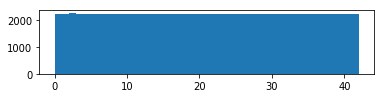

In [9]:
# plot label distribution of training examples
plt.subplot(3,1,2)
n, bins, patches = plt.hist(y_train, 43)

## Step 3: Data preprocessing

In [10]:
def normalize_image(image):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = normalize_image(X_train)
# X_validation = normalize_image(X_validation)
X_test = normalize_image(X_test)


print(X_train.shape)
print(y_train.shape)

num_classes = 43

y_train = keras.utils.to_categorical(y_train, num_classes)
# y_validation = keras.utils.to_categorical(y_validation, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(X_train.shape)
print(y_train.shape)

# shuffle the data set
X_train, y_train = shuffle(X_train, y_train)

(94670, 32, 32, 3)
(94670,)
(94670, 32, 32, 3)
(94670, 43)


----

## Step 4: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [11]:
input_shape = (32, 32, 3)


model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               51328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [12]:
# optimize the model
optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

batch_size = 64
epochs = 1
# epochs = 50

history = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, y_test))

with open("model.json","w") as file:
    json.dump(json.loads(model.to_json()), file)
model.save('model_weight.h5')

Train on 94670 samples, validate on 12630 samples
Epoch 1/1
94670/94670 [==============================] - 32s - loss: 1.3917 - acc: 0.6114 - val_loss: 0.4498 - val_acc: 0.8833

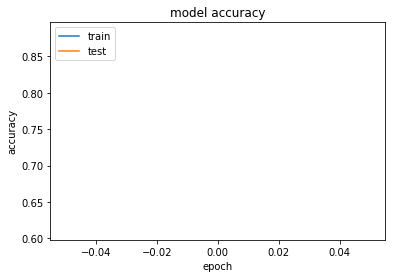

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

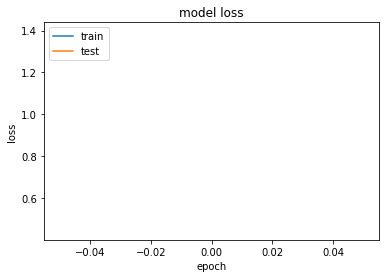

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()